In [14]:
import pandas as pd


#file_path = '.sales.csv'
data = pd.read_csv("sales.csv")

In [15]:

data['date'] = pd.to_datetime(data['date'])  # Convert to datetime format
data['month'] = data['date'].dt.month
data['day_of_month'] = data['date'].dt.day
data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)
data['day_of_week'] = data['date'].dt.dayofweek + 1
data['is_month_end'] = data['date'].dt.is_month_end.astype(int)
data['state_holiday'] = data['state_holiday'].map(lambda x: 0 if x == '0' else 1)

# Interaction Features
data['customer_promotion'] = data['nb_customers_on_day'] * data['promotion']

# Prepare data
X = data.drop(['sales', 'date', 'Unnamed: 0', 'state_holiday','school_holiday'], axis=1)
y = data['sales']

In [16]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'data'
# X = data.drop('sales', axis=1)
# y = data['sales']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

# Define the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the XGBoost model using cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='r2')
print(f"XGBoost Cross-Validation R² Scores: {cv_scores}")
print(f"XGBoost Mean R² Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Fit the model on the full training set
xgb_model.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)

# R² Scores
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"XGBoost Training R² Score: {train_r2:.4f}")
print(f"XGBoost Validation R² Score: {val_r2:.4f}")

# Mean Absolute Error (MAE)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"XGBoost Validation MAE: {val_mae:.4f}")

# Root Mean Squared Error (RMSE)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
print(f"XGBoost Validation RMSE: {val_rmse:.4f}")

# Check for overfitting
if train_r2 - val_r2 > 0.1:  # Adjust the threshold based on your needs
    print("XGBoost may be overfitting.\n")
else:
    print("XGBoost does not appear to be overfitting.\n")



XGBoost Cross-Validation R² Scores: [0.93103434 0.93174855 0.93163993 0.93270463 0.93193881]
XGBoost Mean R² Score: 0.9318 ± 0.0005
XGBoost Training R² Score: 0.9351
XGBoost Validation R² Score: 0.9316
XGBoost Validation MAE: 687.3414
XGBoost Validation RMSE: 1006.3731
XGBoost does not appear to be overfitting.



c:\Users\Salva\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Load the real-life data
real_life_data = pd.read_csv('REAL_DATA.csv')

# Check the first few rows to confirm the date format
print(real_life_data.head())

# Convert date column to datetime with the correct format
# Use the format that matches the date format in your file (e.g., "%d/%m/%Y" for "29/10/2013")
real_life_data['date'] = pd.to_datetime(real_life_data['date'], format='%d/%m/%Y')

# Create necessary date features
real_life_data['month'] = real_life_data['date'].dt.month
real_life_data['day_of_month'] = real_life_data['date'].dt.day
real_life_data['week_of_year'] = real_life_data['date'].dt.isocalendar().week.astype(int)
real_life_data['day_of_week'] = real_life_data['date'].dt.dayofweek + 1
real_life_data['is_month_end'] = real_life_data['date'].dt.is_month_end.astype(int)

# Map state_holiday to numeric as done in training
real_life_data['state_holiday'] = real_life_data['state_holiday'].map(lambda x: 0 if x == '0' else -1)

# Create interaction feature as done in the training phase
real_life_data['customer_promotion'] = real_life_data['nb_customers_on_day'] * real_life_data['promotion']

# Select only the features that were used during the training of the model
X_real_life = real_life_data.drop(['date', 'index', 'state_holiday', 'school_holiday'], axis=1)

# Make predictions on the real evaluation data
predicted_sales = xgb_model.predict(X_real_life)

# Add the predictions to the original data
real_life_data['predicted_sales'] = predicted_sales
# Set predicted sales to zero if the store is closed (open = 0)
real_life_data.loc[real_life_data['open'] == 0, 'predicted_sales'] = 0

# Save the results to a new CSV file or display the first few rows
real_life_data.to_csv('REAL_DATA_with_predictionsv.csv', index=False)

# Display the first few rows of the resulting data with predictions
print(real_life_data.head())


    index  store_ID  day_of_week        date  nb_customers_on_day  open  \
0  272371       415            7  01/03/2015                    0     0   
1  558468        27            7  29/12/2013                    0     0   
2   76950       404            3  19/03/2014                  657     1   
3   77556       683            2  29/01/2013                  862     1   
4  456344       920            3  19/03/2014                  591     1   

   promotion state_holiday  school_holiday  
0          0             0               0  
1          0             0               0  
2          1             0               0  
3          0             0               0  
4          1             0               0  
    index  store_ID  day_of_week       date  nb_customers_on_day  open  \
0  272371       415            7 2015-03-01                    0     0   
1  558468        27            7 2013-12-29                    0     0   
2   76950       404            3 2014-03-19              

In [18]:
# Check basic statistics of the predicted sales
print(real_life_data['predicted_sales'].describe())

# Optionally, compare with statistics from the training set (if available)
# Assuming y_train contains the actual sales values used during training
print(y_train.describe())


count    71205.000000
mean      5767.232910
std       3694.053955
min          0.000000
25%       4010.524414
50%       5892.527344
75%       7750.179199
max      29693.089844
Name: predicted_sales, dtype: float64
count    384504.000000
mean       5777.480606
std        3854.222483
min           0.000000
25%        3729.000000
50%        5745.000000
75%        7861.000000
max       41551.000000
Name: sales, dtype: float64


<Axes: title={'center': 'Distribution of Training Sales'}, ylabel='Frequency'>

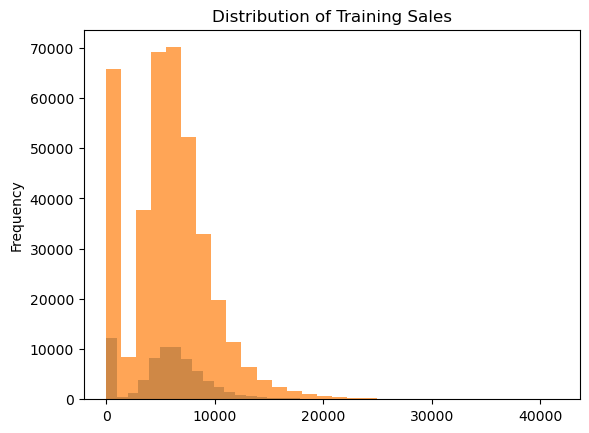

In [19]:
# Plot histogram of predicted sales
real_life_data['predicted_sales'].plot(kind='hist', bins=30, alpha=0.7, title='Distribution of Predicted Sales')

# Optional: Compare with historical sales (if available)
y_train.plot(kind='hist', bins=30, alpha=0.7, title='Distribution of Training Sales')


<Axes: >

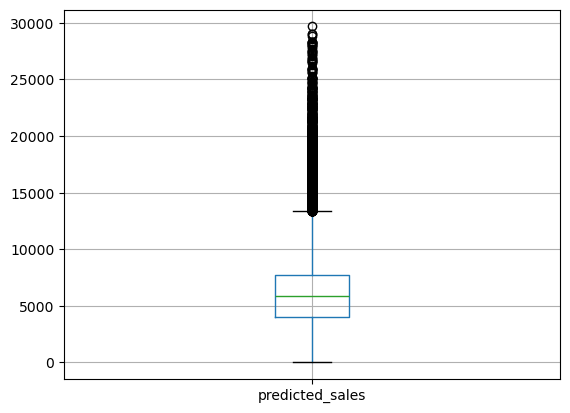

In [20]:
# Plot boxplot of predicted sales to check for outliers
real_life_data.boxplot(column='predicted_sales')


In [9]:
# Check correlation between predicted sales and other features
print(real_life_data[['predicted_sales', 'nb_customers_on_day', 'promotion']].corr())


                     predicted_sales  nb_customers_on_day  promotion
predicted_sales             1.000000             0.933381   0.470088
nb_customers_on_day         0.933381             1.000000   0.314851
promotion                   0.470088             0.314851   1.000000


count    7.120500e+04
mean     1.314061e-25
std      5.137699e-25
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.323489e-23
Name: variance, dtype: float64
           pred1      pred2      pred3       mean      variance
40065  12308.552  12308.552  12308.552  12308.552  3.308722e-24
8862   12791.075  12791.075  12791.075  12791.075  3.308722e-24
29429  11167.908  11167.908  11167.908  11167.908  3.308722e-24
9147   11717.588  11717.588  11717.588  11717.588  3.308722e-24
41196  13452.825  13452.825  13452.825  13452.825  3.308722e-24
...          ...        ...        ...        ...           ...
40747  14182.522  14182.522  14182.522  14182.522  3.308722e-24
64948  11418.766  11418.766  11418.766  11418.766  3.308722e-24
47140  11132.609  11132.609  11132.609  11132.609  3.308722e-24
55958  12701.446  12701.446  12701.446  12701.446  3.308722e-24
19673  11604.270  11604.270  11604.270  11604.270  3.308722e-24

[1023 rows x 5 columns]


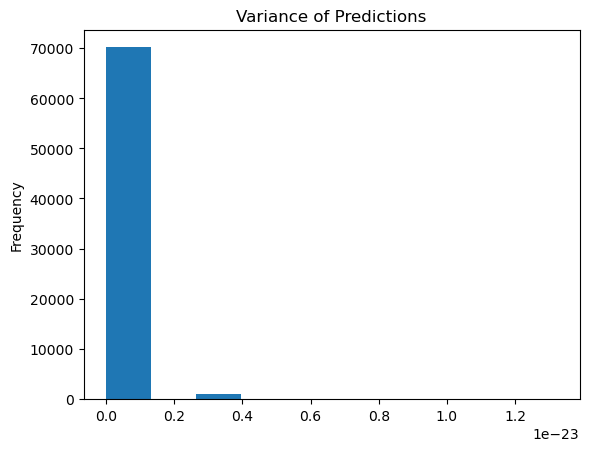

In [24]:
import pandas as pd

# Load multiple prediction files
pred1 = pd.read_csv('REAL_DATA_with_predictions.csv')
pred2 = pd.read_csv('REAL_DATA_with_predictionsv2.csv')
pred3 = pd.read_csv('REAL_DATA_with_predictionsv3.csv')

# Merge or align the data if needed (ensure all predictions are comparable)
pred1 = pred1.sort_values('date')
pred2 = pred2.sort_values('date')
pred3 = pred3.sort_values('date')

# Combine predictions into a DataFrame
comparison = pd.DataFrame({
    'pred1': pred1['predicted_sales'],
    'pred2': pred2['predicted_sales'],
    'pred3': pred3['predicted_sales']
})

# Calculate mean and variance of the predictions
comparison['mean'] = comparison.mean(axis=1)
comparison['variance'] = comparison.var(axis=1)

# Summary statistics of variance
print(comparison['variance'].describe())

# Plot the variance to visually inspect consistency
comparison['variance'].plot(kind='hist', title='Variance of Predictions')

# Check specific rows with high variance to understand differences
high_variance = comparison[comparison['variance'] > comparison['variance'].quantile(0.95)]
print(high_variance)
